# Color correction análysis

In [33]:
from exp import *

In [34]:
dm = DatasetManager('2017',224,'all','2017')

In [35]:
dm.generate_dataset('train_images')

# dm.generate_dataset('valid_images')

here
resizing to 224 into 2017_train_images_resized_to_224_picked_all_training_for_2017


PosixPath('2017_train_images_resized_to_224_picked_all_training_for_2017')

# Color Balance

In [36]:
train_imgs = dm.get_dataset_path('train_images')

In [37]:
len(train_imgs.ls())

2000

In [98]:
mel_imgs_paths = [img_path for img_path in train_imgs.ls() if dm.get_label_for_image_path(img_path) == 'melanoma']
other_imgs_paths = [img_path for img_path in train_imgs.ls() if dm.get_label_for_image_path(img_path) != 'melanoma']

In [ ]:
map(get_channels_mean_for_image_path, mel_imgs_paths)

In [161]:
def get_channels_mean_for_image_path(img_path):
    red_avg, green_avg, blue_avg = open_image(img_path).data.mean(dim=(1,2))
    return [red_avg, green_avg, blue_avg]

def get_red_channel_mean_for_image_path(img_path):
    return get_channels_mean_for_image_path(img_path)[0].item()

def get_green_channel_mean_for_image_path(img_path):
    return get_channels_mean_for_image_path(img_path)[1].item()

def get_blue_channel_mean_for_image_path(img_path):
    return get_channels_mean_for_image_path(img_path)[2].item()


def get_list_of_channels_mean_for_list_of_image_paths(list_of_image_paths):
    list_of_channels_mean_per_image = list(map(get_channels_mean_for_image_path, list_of_image_paths))
    red_channel_mean_per_image = list(map(lambda means: means[0], list_of_channels_mean_per_image))
    green_channel_mean_per_image = list(map(lambda means: means[1], list_of_channels_mean_per_image))
    blue_channel_mean_per_image = list(map(lambda means: means[2], list_of_channels_mean_per_image))
    return [red_channel_mean_per_image,green_channel_mean_per_image,blue_channel_mean_per_image]


In [162]:
mel_mean_reds, mel_mean_green, mel_mean_blues = get_list_of_channels_mean_for_list_of_image_paths(mel_imgs_paths)

other_mean_reds, other_mean_green, other_mean_blues = get_list_of_channels_mean_for_list_of_image_paths(other_imgs_paths)


In [185]:
list(zip([1,2],[2,3],[3,4]))

[(1, 2, 3), (2, 3, 4)]

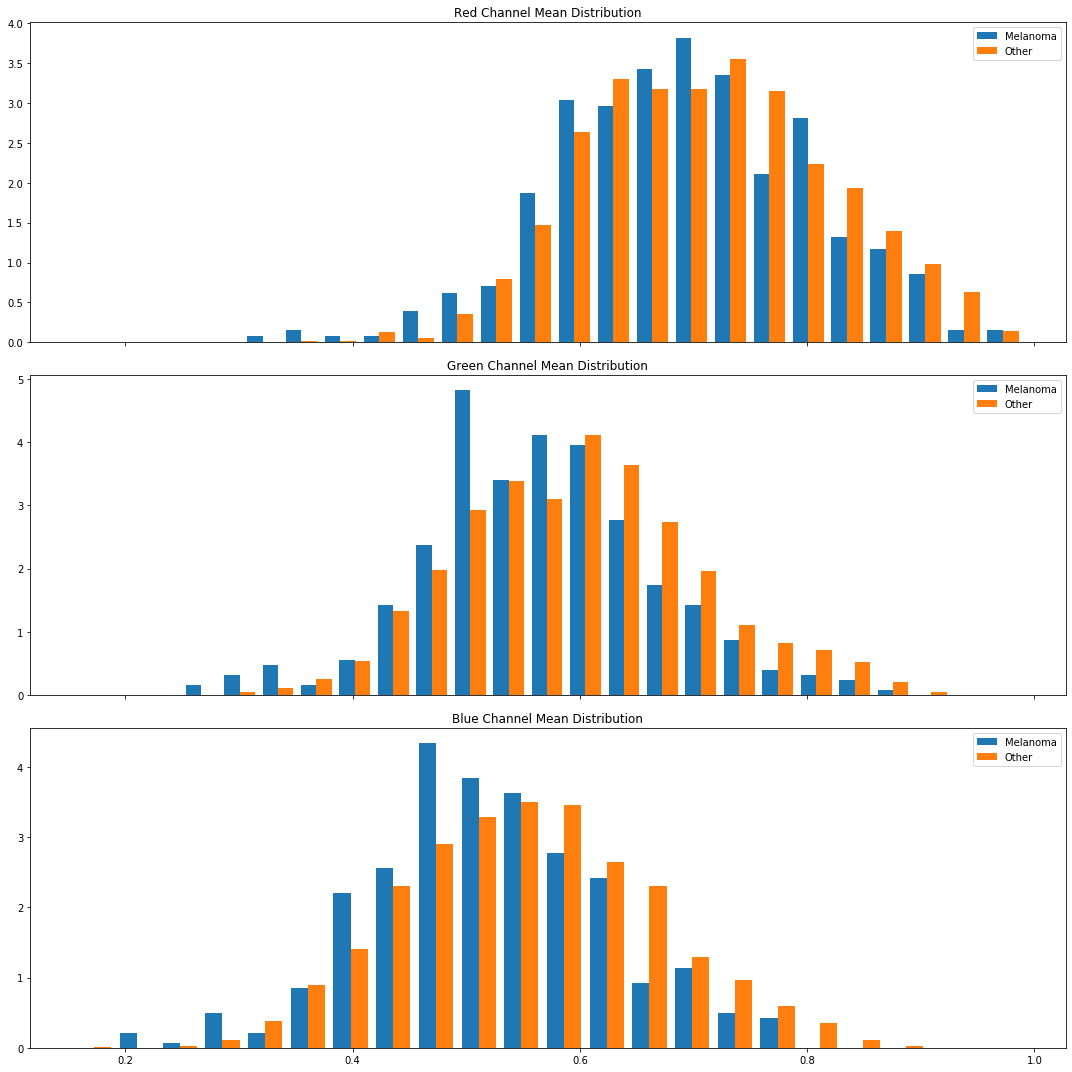

In [186]:
fig, axs = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(15,15))

names = ['Melanoma',"Other"]

axs[0].hist([mel_mean_reds,other_mean_reds],bins=20,histtype='bar',density=True,label=names)
axs[0].set_title('Red Channel Mean Distribution')
axs[0].legend()

axs[1].hist([mel_mean_green,other_mean_green],bins=20,histtype='bar',density=True,label=names)
axs[1].set_title('Green Channel Mean Distribution')
axs[1].legend()

axs[2].hist([mel_mean_blues,other_mean_blues],bins=20,histtype='bar',density=True,label=names)
axs[2].set_title('Blue Channel Mean Distribution')
axs[2].legend()

# Training a Model

In [4]:
len(dm.get_dataset_path('train_images').ls())

2001

In [5]:
len(dm.get_dataset_path('valid_images').ls())

150

In [19]:
dm.get_label_for_image_path()

<bound method DatasetManager.get_label_for_image_path of <exp.nb_DatasetManager.DatasetManager object at 0x7f8a070cd710>>

In [6]:
def reload_dataset(dm,seed=1):
    random_seed(seed,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.1, max_lighting=0,p_affine=1, max_warp=0)

    data = ImageList.from_folder(dm.get_dataset_path('train_images').parent)\
    .split_by_folder(train=dm.get_dataset_path('train_images').name,
                   valid=dm.get_dataset_path('valid_images').name)\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=128)\
    .databunch(bs=16)\
    .normalize()
    return data

data = reload_dataset(dm)

In [18]:
mel_list = [sample for sample in data.train_ds if sample[1] == 'melanoma']

AttributeError: 'str' object has no attribute 'data'

In [17]:
a

LabelList (2000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
seborrheic_keratosis_or_nevus,melanoma,seborrheic_keratosis_or_nevus,seborrheic_keratosis_or_nevus,seborrheic_keratosis_or_nevus
Path: .

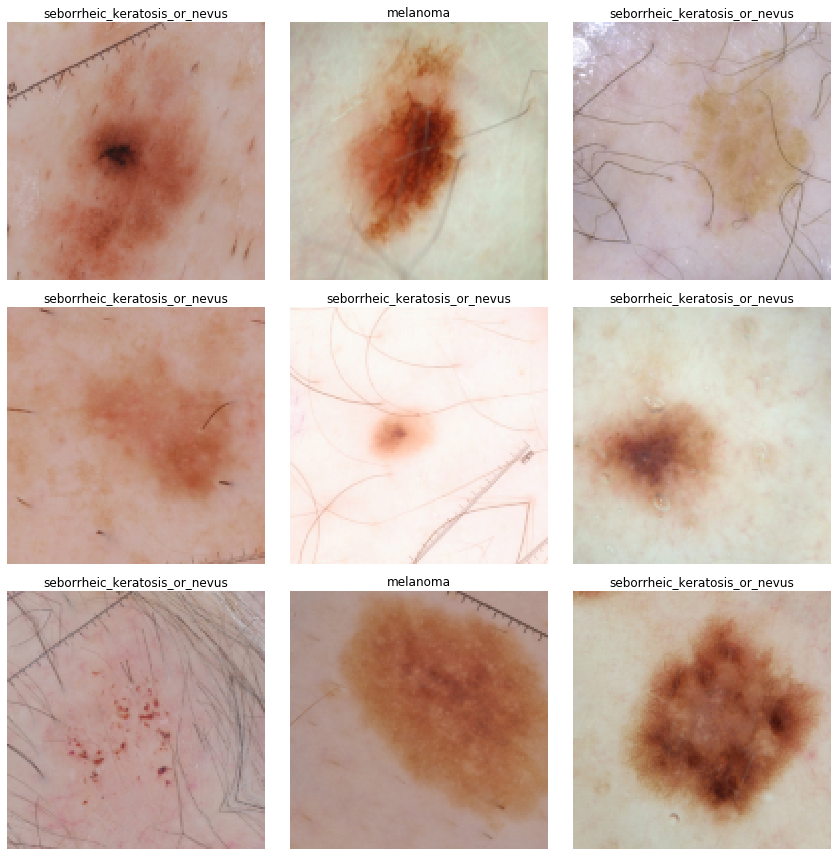

In [88]:
data.show_batch(3)

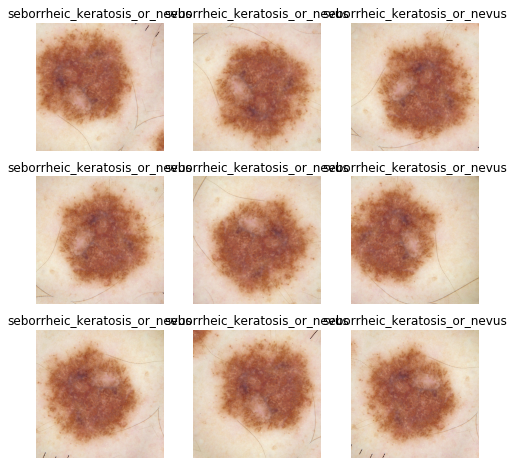

In [89]:
def _plot(i,j,ax,img_index=0):
    x,y = data.train_ds[img_index]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [90]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 seborrheic_keratosis_or_nevus    1626
melanoma                          374
dtype: int64 

 valid_count: 
 seborrheic_keratosis_or_nevus    120
melanoma                          30
dtype: int64
ratios:
seborrheic_keratosis_or_nevus    0.073801
melanoma                         0.080214
dtype: float64 %


# Lets test a baseline

In [91]:
random_seed(1,True)
learn = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph], 
                        pretrained=False)

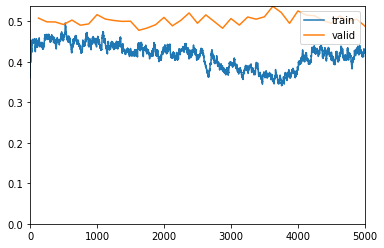

In [93]:
random_seed(1,True)
learn.fit_one_cycle(40,max_lr=slice(1.10E-04))

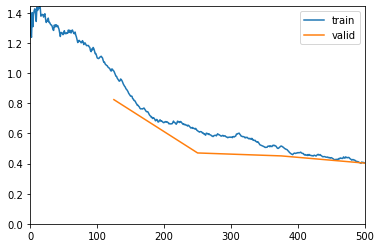

In [11]:
random_seed(1,True)
learn.fit_one_cycle(4)

In [12]:
learn.unfreeze()

In [75]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 2.75E-05


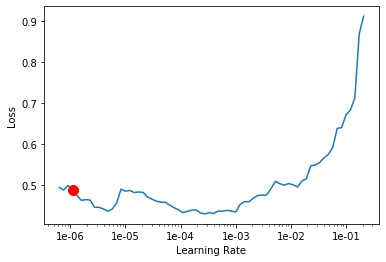

In [76]:
learn.recorder.plot(suggestion=True)

In [77]:
learn.recorder.min_grad_lr

1.096478196143185e-06

In [13]:
learn.save('color_analysis_head_trained')

In [14]:
learn.load('color_analysis_head_trained')

Learner(data=ImageDataBunch;

Train: LabelList (2000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
seborrheic_keratosis_or_nevus,melanoma,seborrheic_keratosis_or_nevus,seborrheic_keratosis_or_nevus,seborrheic_keratosis_or_nevus
Path: .;

Valid: LabelList (150 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
seborrheic_keratosis_or_nevus,melanoma,seborrheic_keratosis_or_nevus,seborrheic_keratosis_or_nevus,seborrheic_keratosis_or_nevus
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottlen

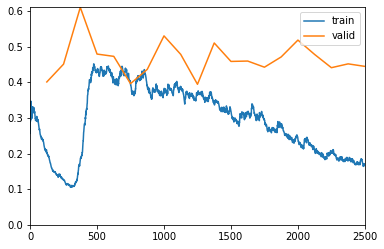

In [15]:
random_seed(1,True)
learn.fit_one_cycle(20,max_lr=slice(1.10E-03))

In [59]:
interp = ClassificationInterpretation.from_learner(learn)

In [61]:
(12 + 119) / 150

0.8733333333333333

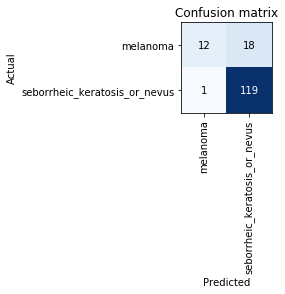

In [60]:
interp.plot_confusion_matrix()

# Color correction

In [29]:
def correct_iluminant(estimated_iluminant):
    perfect_white_light = (torch.ones(3) / math.sqrt(3))
    corrected_iluminant = perfect_white_light * (1 / estimated_iluminant)
    return corrected_iluminant

def correct_image(image,estimated_iluminant):
    corrected_iluminant = correct_iluminant(estimated_iluminant)
    mat_iluminant = corrected_iluminant[:,None,None].expand(image.shape)
    c = mat_iluminant * image
    return c

def gamma_correction_step(image,gamma):
    return image ** gamma

## Max RGB

In [39]:
def max_rgb(image):
  # First get the maximum across the rows, then take the values and take the maximum again (this time dimension 1 will be the columns)
    e = image.max(dim=1)[0].max(dim=1)[0]
    k = 1 / torch.norm(e)
    return e * k

def _correct_color_max_rgb(image):
    image = gamma_correction_step(image,gamma=1/2.2)
    estimated_iluminant = max_rgb(image);
    c = correct_image(image,estimated_iluminant)
    return c

correct_color_max_rgb = TfmPixel(_correct_color_max_rgb)


## Shades of gray / gray world

In [40]:
def shades_of_gray(image, p):
    image = gamma_correction_step(image,gamma=1/2.2)
    e = ((image ** p).sum(dim=[1,2]) / image.sum()) ** (1/p)
    k = 1 / torch.norm(e)
    return e * k


def _correct_color_shades_of_gray(p):
    def _correct_color_shades_of_gray(image):
        estimated_iluminant = shades_of_gray(image,p);
        c = correct_image(image,estimated_iluminant)
        return torch.clamp(c,0,1)
    return _correct_color_shades_of_gray


def _correct_color_gray_world(image):
    return _correct_color_shades_of_gray(image,1)


# CHOOSE THIS PARAMETER
p = 6
correct_color_shades_of_gray = TfmPixel(_correct_color_shades_of_gray(p))

## Show color correction changes

### Baseline

In [41]:
data = reload_dataset(dm)

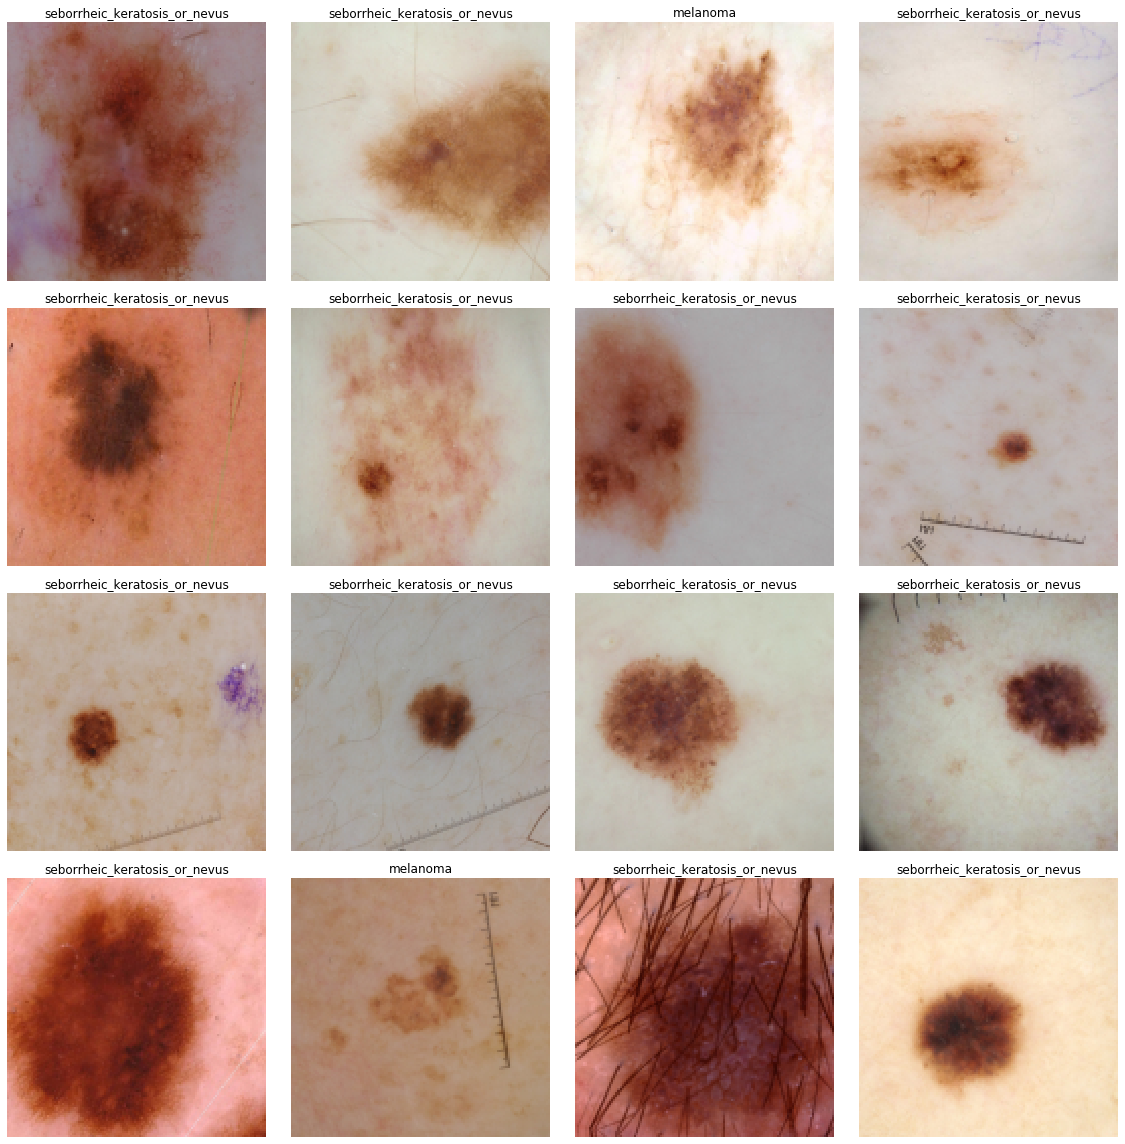

In [42]:
random_seed(1,True)
data.show_batch()

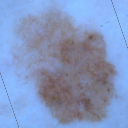

In [43]:
random_seed(1,True)
data.train_ds[1][0]

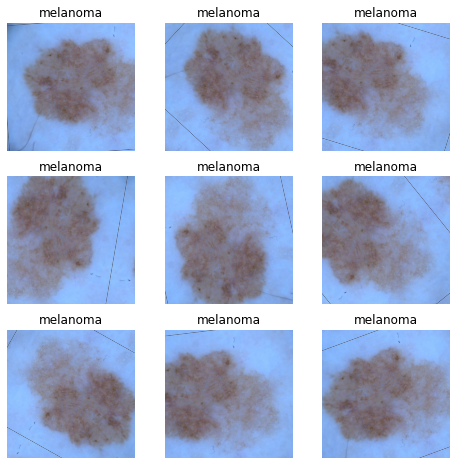

In [44]:
plot_multi(partial(_plot,img_index=1), 3, 3, figsize=(8,8))

### Max rgb

In [45]:
data = reload_dataset(dm)

In [46]:
correct_color_max_rgb.order = 0
data.train_ds.tfms.insert(10,correct_color_max_rgb());
data.valid_ds.tfms.insert(10,correct_color_max_rgb());

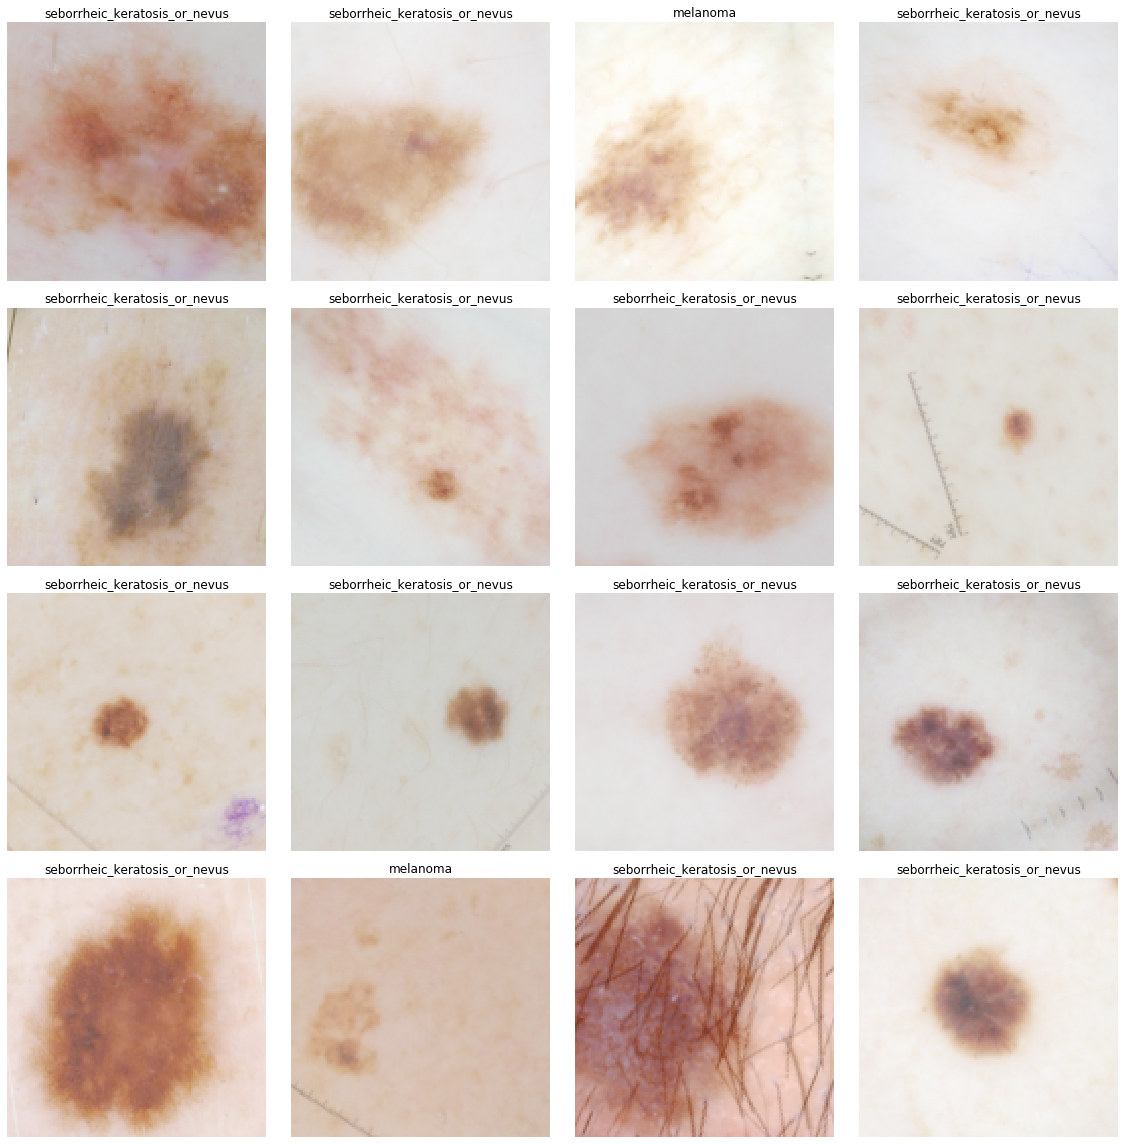

In [47]:
random_seed(1,True)
data.show_batch()

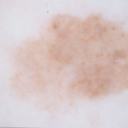

In [48]:
random_seed(1,True)
data.train_ds[1][0]

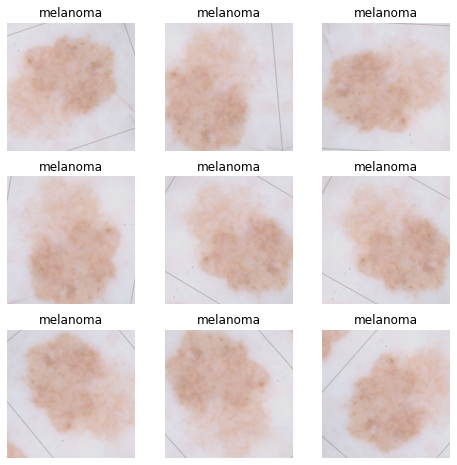

In [49]:
plot_multi(partial(_plot,img_index=1), 3, 3, figsize=(8,8))

## Train color correction

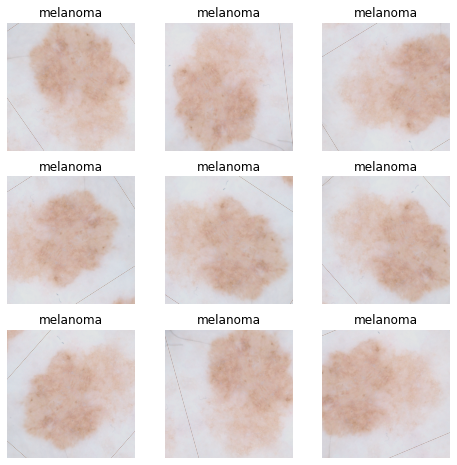

In [57]:
data = reload_dataset(dm)
correct_color_max_rgb.order = 1000 
data.train_ds.tfms.insert(0,correct_color_max_rgb());
data.valid_ds.tfms.insert(0,correct_color_max_rgb());

plot_multi(partial(_plot,img_index=1), 3, 3, figsize=(8,8))

In [58]:
sorted(data.train_ds.tfms, key=lambda x: x.order)

[RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={'k': 5}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-180, 180)}, p=1, resolved={'degrees': -67.21889001518593}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1, resolved={'scale': 1.0913392017165942, 'row_pct': 0.9698132768381156, 'col_pct': 0.9697965044964699}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={'row_pct': 0.21519327003609845, 'col_pct': 0.6178068800115557, 'padding_mode': 'reflection'}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmPixel (correct_color_max_rgb), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)]

In [59]:
random_seed(1,True)
learn = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph], 
                        pretrained=True)

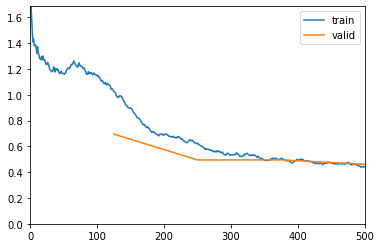

In [60]:
random_seed(1,True)
learn.fit_one_cycle(4)

In [61]:
learn.unfreeze()

In [97]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-06
Min loss divided by 10: 2.75E-05


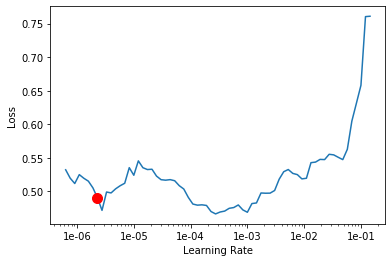

In [98]:
learn.recorder.plot(suggestion=True)

In [55]:
learn.save('color_analysis_head_trained')

In [48]:
learn.load('color_analysis_head_trained')

Learner(data=ImageDataBunch;

Train: LabelList (2000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
seborrheic_keratosis_or_nevus,melanoma,seborrheic_keratosis_or_nevus,seborrheic_keratosis_or_nevus,seborrheic_keratosis_or_nevus
Path: .;

Valid: LabelList (150 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
seborrheic_keratosis_or_nevus,melanoma,seborrheic_keratosis_or_nevus,seborrheic_keratosis_or_nevus,seborrheic_keratosis_or_nevus
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottlen

In [64]:
# shades p 6

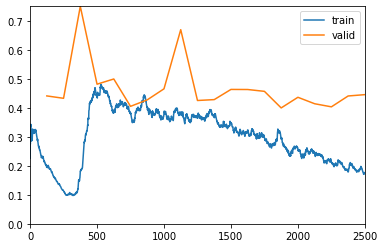

In [56]:
random_seed(1,True)
learn.fit_one_cycle(20,max_lr=slice(1.10E-03))

In [63]:
# max rgb

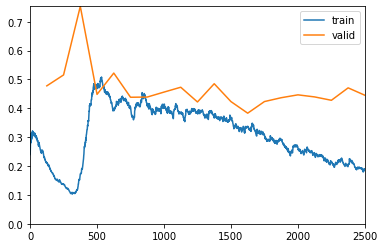

In [62]:
random_seed(1,True)
learn.fit_one_cycle(20,max_lr=slice(1.10E-03))

# Comparison for various seeds

In [102]:
def simple_train(learner,seed, epochs):
    random_seed(seed,True)
    learner.fit_one_cycle(4)

    learner.unfreeze()

    random_seed(seed,True)
    learner.fit_one_cycle(epochs,max_lr=slice(1.10E-04))

In [103]:
columns = ['Without Color Correction','With Max RGB']
','.join(columns) + '\n'

'Without Color Correction,With Max RGB\n'

In [104]:
results_file_name = 'color_analysis_run_seed'
columns = ['Without Color Correction','With Max RGB']
def write_results(seed,first_learner,second_learner):
    l1 = list(map(lambda x: x[1], first_learner.recorder.metrics))
    l2 = list(map(lambda x: x[1], second_learner.recorder.metrics))

    f = open(f'{results_file_name}_{s}.txt','w+')
    f.write(','.join(columns) + '\n')
    run = ''.join(map(str,[f'{a.item()},{b.item()}\n' for a,b in zip(l1,l2) ]))
    f.write(run)
    f.close()

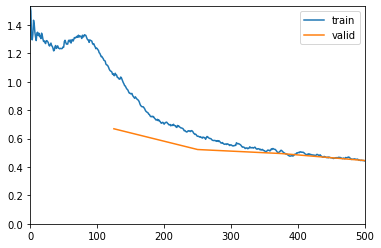

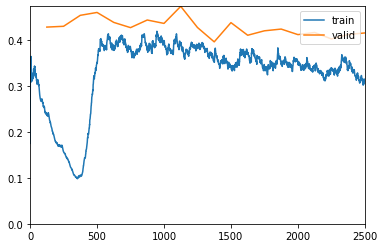

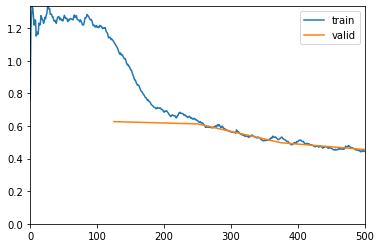

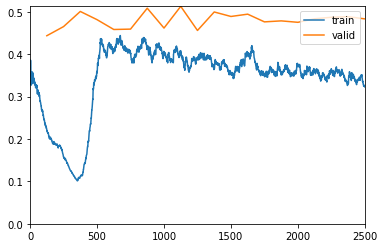

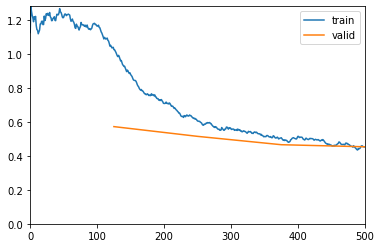

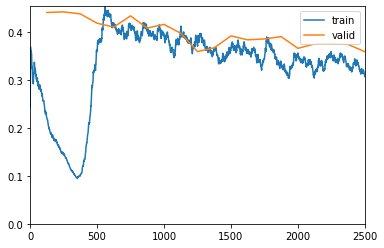

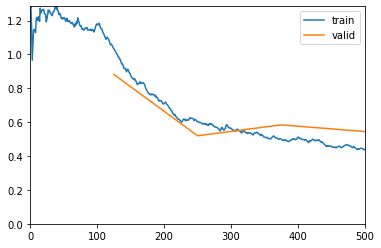

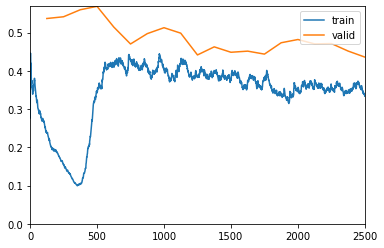

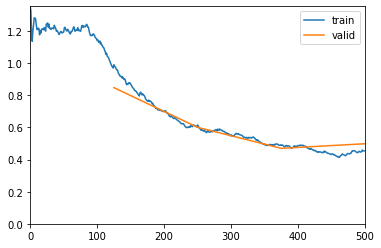

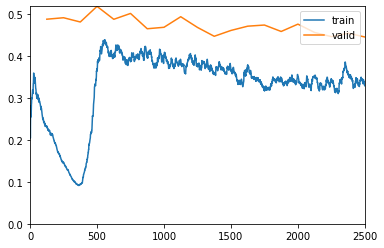

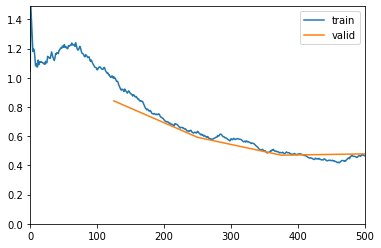

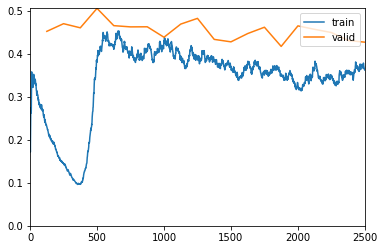

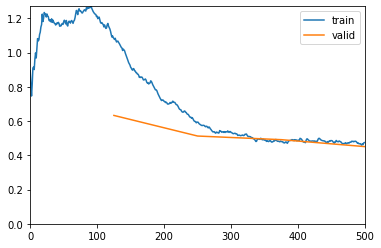

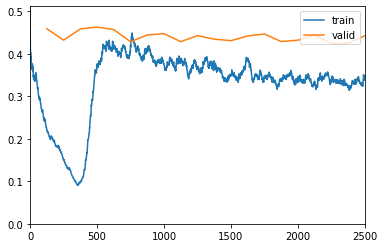

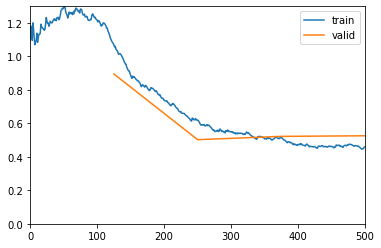

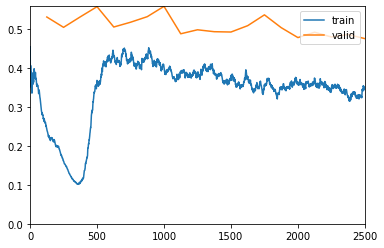

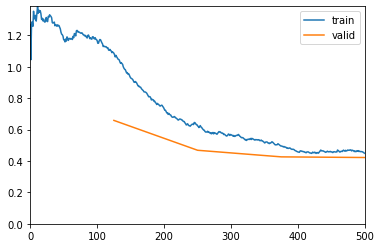

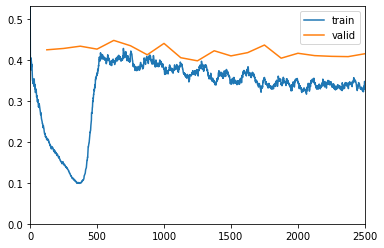

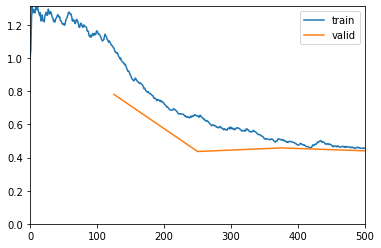

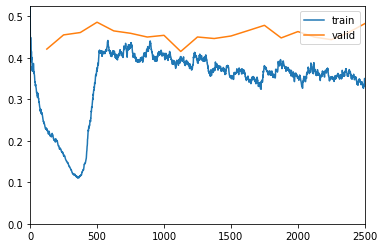

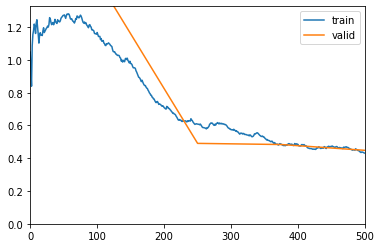

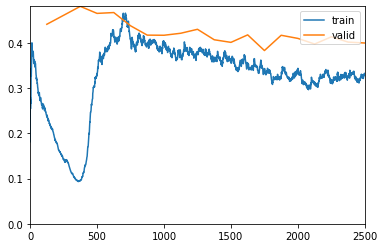

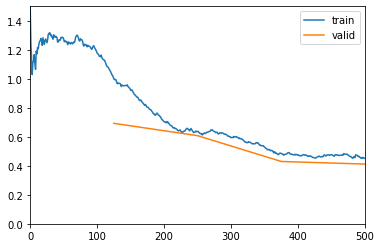

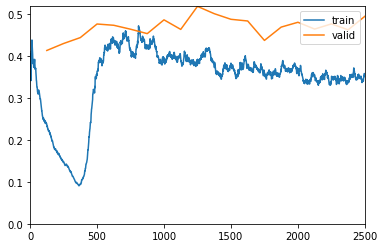

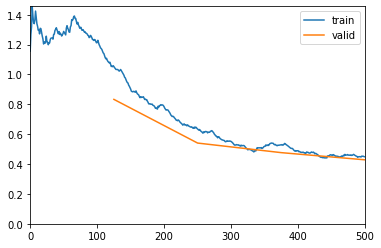

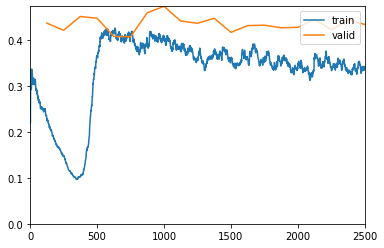

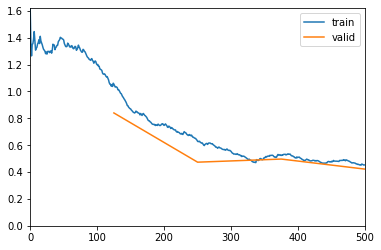

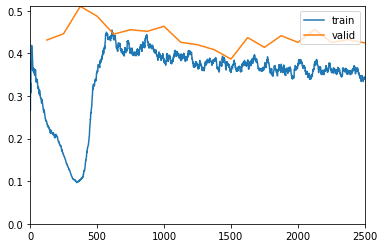

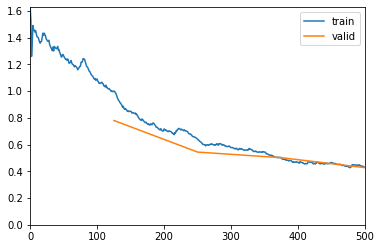

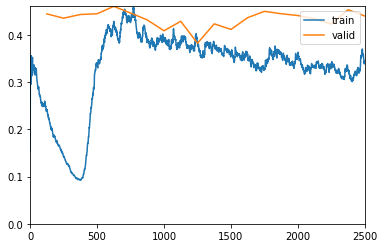

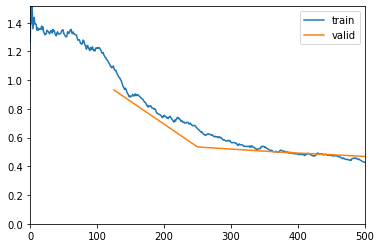

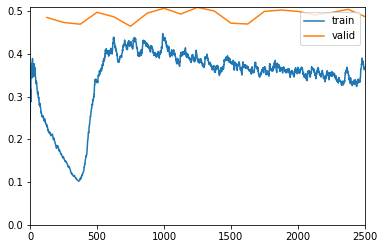

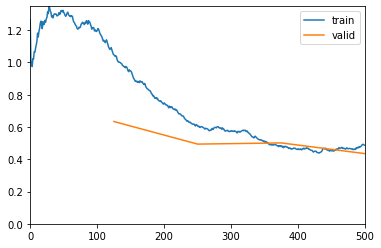

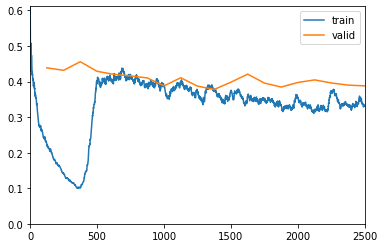

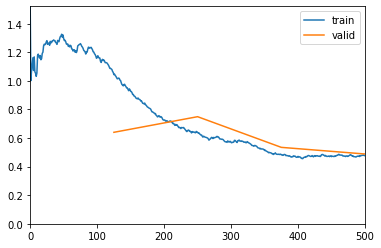

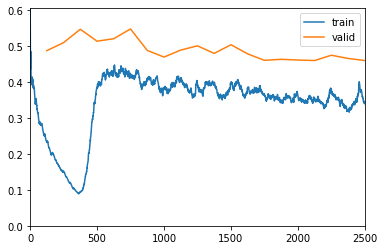

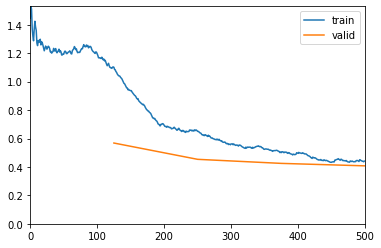

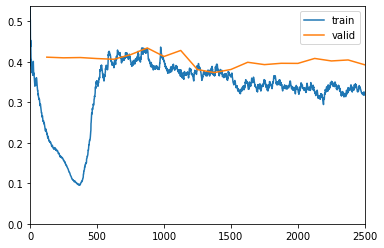

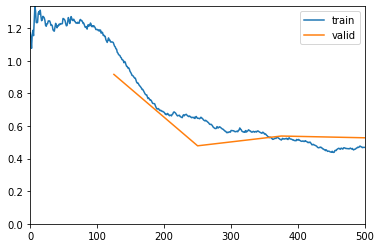

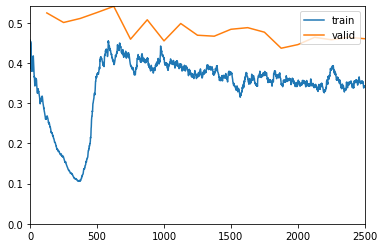

In [105]:
seeds = [1,2,3,4,5,6,7,8,9,10]
epochs = 20

for s in seeds:
    data = reload_dataset(dm,s)    
    random_seed(s,True)
    
    #No color correction
    learn = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph], 
                        pretrained=True)

    
    simple_train(learn,s,epochs)

    
    #Con color correction
    data = reload_dataset(dm,s)
    
    random_seed(s,True)
    
    # Insertamos en train como en valid ds, la correcion de color Max rgb en la primer posicion
    correct_color_max_rgb.order = 0 
    data.train_ds.tfms.insert(0,correct_color_max_rgb());
    data.valid_ds.tfms.insert(0,correct_color_max_rgb());

    random_seed(s,True)

    learn_max_rgb = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph], 
                        pretrained=True)

    simple_train(learn_max_rgb, s,epochs)
    
    write_results(s, learn, learn_max_rgb)
    

# Analyze results

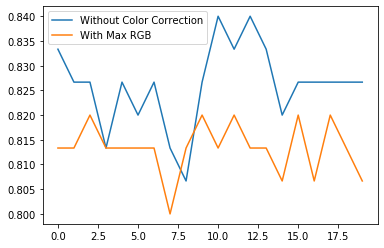

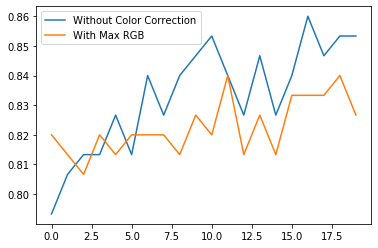

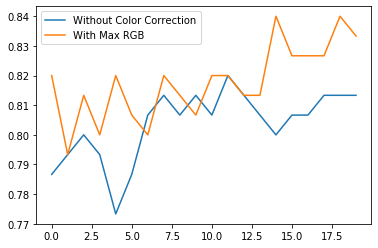

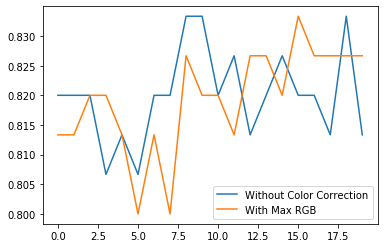

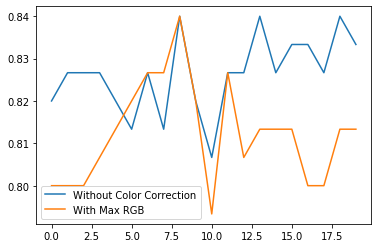

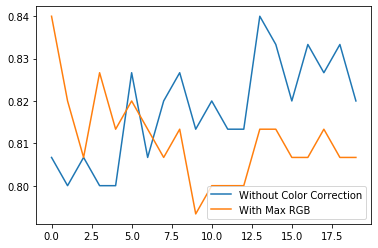

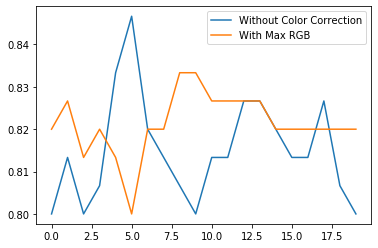

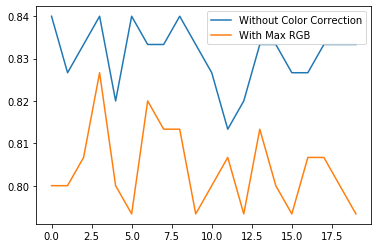

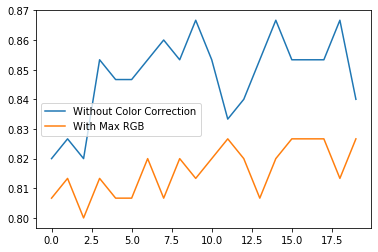

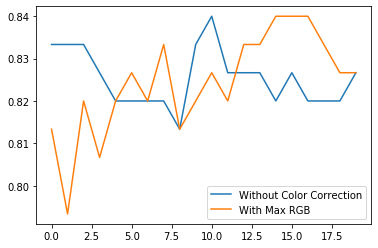

In [106]:
runs = {}
for i in range(1,11):
    runs[i] = pd.read_csv(f'{results_file_name}_{i}.txt')
    runs[i].plot()

In [107]:
max_acc_for_each_run_max_rgb = [runs[r].max()['With Max RGB'] for r in runs]
max_acc_for_each_run_baseline = [runs[r].max()['Without Color Correction'] for r in runs]

In [108]:
df = pd.DataFrame({
                    'Baseline':max_acc_for_each_run_baseline,
                    'Max RGB': max_acc_for_each_run_max_rgb
                })

In [109]:
df.describe()

Baseline    Max RGB
count  10.000000  10.000000
mean    0.842667   0.834000
std     0.013034   0.007337
min     0.820000   0.820000
25%     0.840000   0.828333
50%     0.840000   0.836667
75%     0.845000   0.840000
max     0.866667   0.840000

In [110]:
avg_max_rgb_acc = np.mean(max_acc_for_each_run_max_rgb)
std_max_rgb_acc = np.std(max_acc_for_each_run_max_rgb)



avg_baseline_acc = np.mean(max_acc_for_each_run_baseline)
std_baseline_acc = np.std(max_acc_for_each_run_baseline)

In [111]:
avg_max_rgb_acc,std_max_rgb_acc

(0.8339999794960022, 0.006960197701505584)

In [112]:
avg_baseline_acc,std_baseline_acc

(0.8426666557788849, 0.012364834721592177)

In [ ]:


times_max_rgb_had_higher_acc = [runs[i].max()['Without Color Correction'] < runs[i].max()[' Max_RGB'] for i in runs]

arl_effectiveness = sum(times_max_rgb_had_higher_acc)/ len(runs)

print(f'MAX RGB improved the Accuracy in {arl_effectiveness*100}% of the cases')